In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.style.use('bmh')
import seaborn as sns
from scipy import stats

from pandas_datareader.data import DataReader

# Data

**S&P CoreLogic Case-Shiller U.S. National Home Price Index**  

[Description](https://fred.stlouisfed.org/series/CSUSHPISA)  

Downloaded from the [FRED database](https://fred.stlouisfed.org/) using [pandas-datareader](https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#remote-data-fred).

In [2]:
returns = pd.read_excel('portfolio_returns.xlsx', names=['Date', 'returns'])
returns.set_index('Date', inplace=True)

FileNotFoundError: [Errno 2] No such file or directory: 'portfolio_returns.xlsx'

In [3]:
#Case-Shiller
returns = pd.read_excel('Case-Shiller.xlsx').set_index('DATE')
returns.head()

,CSUSHPISA
DATE,
1987-02-01,0.007192
1987-03-01,0.004827
1987-04-01,0.006117
1987-05-01,0.006664
1987-06-01,0.007733


In [43]:
data = DataReader('CSUSHPISA', 'fred', start='1987')
data.head()

,CSUSHPISA
DATE,
1987-01-01,63.963
1987-02-01,64.423
1987-03-01,64.734
1987-04-01,65.130
1987-05-01,65.564


In [44]:
ret = data.pct_change().dropna()
ret = ret.asfreq('MS')
ret.tail()

,CSUSHPISA
DATE,
2024-09-01,0.003140
2024-10-01,0.003650
2024-11-01,0.004690
2024-12-01,0.004813
2025-01-01,0.005675


In [6]:
ret.to_excel('Case-Shiller.xlsx')

In [7]:
returns

,CSUSHPISA
DATE,
1987-02-01,0.007192
1987-03-01,0.004827
1987-04-01,0.006117
1987-05-01,0.006664
1987-06-01,0.007733
...,...
2024-09-01,0.003140
2024-10-01,0.003650
2024-11-01,0.004690


In [8]:
ret

,CSUSHPISA
DATE,
1987-02-01,0.007192
1987-03-01,0.004827
1987-04-01,0.006117
1987-05-01,0.006664
1987-06-01,0.007733
...,...
2024-09-01,0.003140
2024-10-01,0.003650
2024-11-01,0.004690


## Plot the data

In [9]:
def plot_data_qqplot(data):
    fig = plt.figure(figsize=(10,8), layout='tight')
    ax_data = fig.add_subplot(2,1,1)
    ax_hist = fig.add_subplot(2,2,3)
    ax_pplot = fig.add_subplot(2,2,4)

    # plot the data
    ax_data.plot(data)
    ax_data.axhline(0, c='k', ls=':', lw=.5)
    ax_data.yaxis.set_major_formatter(mtick.PercentFormatter(1))
    ax_data.set_title("Monthly Percent Change")

    # plot an histogram + kde + MLE normal fit
    mu, sigma = stats.norm.fit(data)
    x = np.linspace(data.min(), data.max(), 200)
    pdf_norm = stats.norm.pdf(x, loc=mu, scale=sigma)
    sns.histplot(data, bins=40, kde=True, stat='density', ax=ax_hist)
    ax_hist.plot(x, pdf_norm, c='r', lw=2)
    ax_hist.xaxis.set_major_formatter(mtick.PercentFormatter(1))
    label = fr"Normal fit ($\mu$={mu:.2%}, $\sigma$={sigma:.2%})"
    lines = ax_hist.get_lines()
    ax_hist.legend(lines, ['kde', label], fontsize='small')
    ax_hist.set_title("Histogram")

    stats.probplot(data.values[:,0], plot=ax_pplot)
    ax_pplot.set_title("Normal Probability plot")

    fig.suptitle("Case-Shiller U.S. National Home Price Index")
    

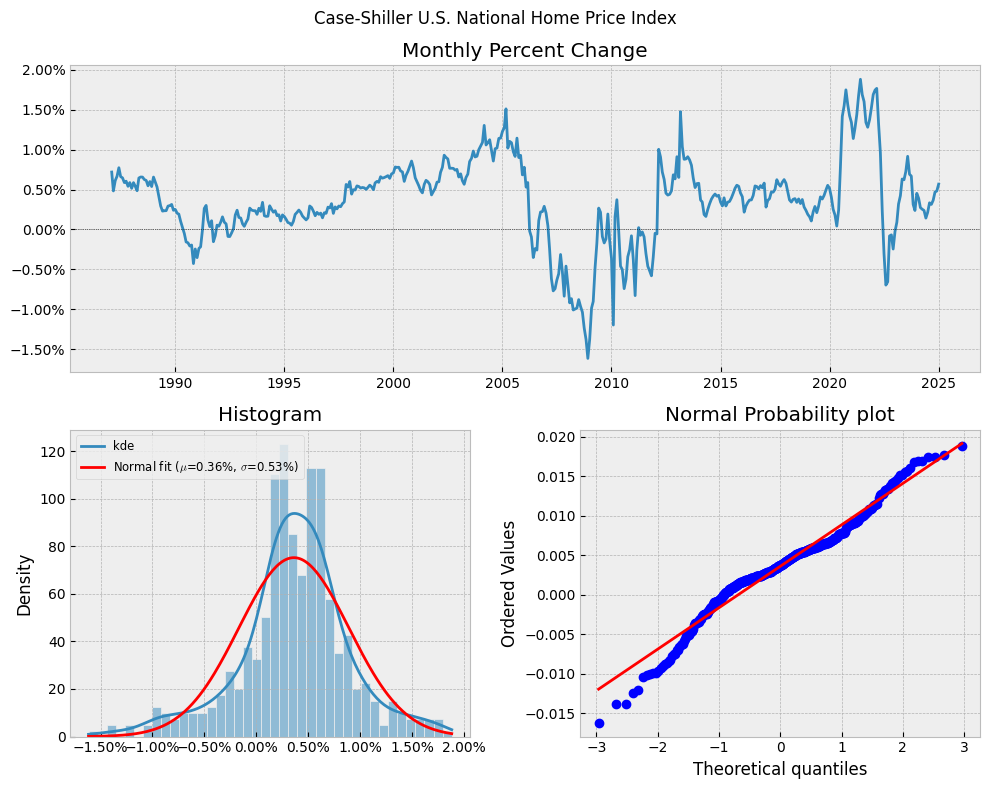

In [10]:
plot_data_qqplot(ret)

# Tests of stationarity

## Augmented Dickey-Fuller unit root test  

The **Null hypothesis** of the [Augmented Dickey-Fuller test](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) is that there is a unit root vs. the **Alternative hypothesis** of stationarity.  

The ADF test uses the regression
$$\Delta X_t = \alpha + \beta t + \Phi X_{t-1} + \gamma_1 \Delta X_{t-1} + \dotsm + \gamma_{p-1} \Delta X_{t-p+1} + \varepsilon_t$$
to test the significance of $\Phi$.

The parameter `regression` takes the values
- `n` ($\alpha = 0$, $\beta = 0$)
- `c` ($\alpha \neq 0$, $\beta = 0$)
- `ct` ($\alpha \neq 0$, $\beta \neq 0$)

In [11]:
from statsmodels.tsa.api import adfuller

In [12]:
def print_adf_test(x):
    regressions = {'no constant, no trend': 'n',
                   'constant only': 'c',
                   'constant and trend': 'ct'}
    df = pd.DataFrame(data=np.zeros((len(regressions),2)),
                      index=regressions,
                      columns=['test statistic', 'p-value'])
    for reg in regressions:
        res = adfuller(x, regression=regressions[reg])
        df.loc[reg, 'test statistic'] = res[0]
        df.loc[reg, 'p-value'] = res[1]
    display(df.round(4))

In [13]:
print_adf_test(ret)

,test statistic,p-value
"no constant, no trend",-2.3015,0.0206
constant only,-2.8965,0.0458
constant and trend,-2.9692,0.1409


## KPSS test  

The null hypothesis for the [KPSS test](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.kpss.html) is
- `regression='c'`: the data is stationary around a constant (default).
- `regression='ct'`: the data is stationary around a trend.

In [14]:
from statsmodels.tsa.api import kpss

In [15]:
def print_kpss_test(x, regression='c'):
    regressions = {'constant only': 'c',
                   'constant and trend': 'ct'}
    df = pd.DataFrame(data=np.zeros((len(regressions),2)),
                      index=regressions,
                      columns=['test statistic', 'p-value'])
    for reg in regressions:
        res = kpss(x, regression=regressions[reg], nlags='auto')
        df.loc[reg, 'test statistic'] = res[0]
        df.loc[reg, 'p-value'] = res[1]
    display(df.round(4))

In [16]:
print_kpss_test(ret)

C:\Users\quent\AppData\Local\Temp\ipykernel_30276\3569781587.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  res = kpss(x, regression=regressions[reg], nlags='auto')


,test statistic,p-value
constant only,0.1894,0.1000
constant and trend,0.1425,0.0564


# Testing the data for autocorrelation

## Plot the *autocorrelation* function and the *partial autocorrelation* function  

- [`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)
- [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html)

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [18]:
def plot_acf_pacf(x, lags=30):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(x, lags=lags, ax=axs[0])
    plot_pacf(x, lags=lags, ax=axs[1])
    
    # add the 95% confidence interval using variance = 1/N
    stderr = stats.norm.ppf(.975) / np.sqrt(len(x))
    for ax in axs:
        ax.hlines([stderr, -stderr], 0, lags, colors='r', linestyles='dotted', label='95% confidence interval')
        ax.legend()

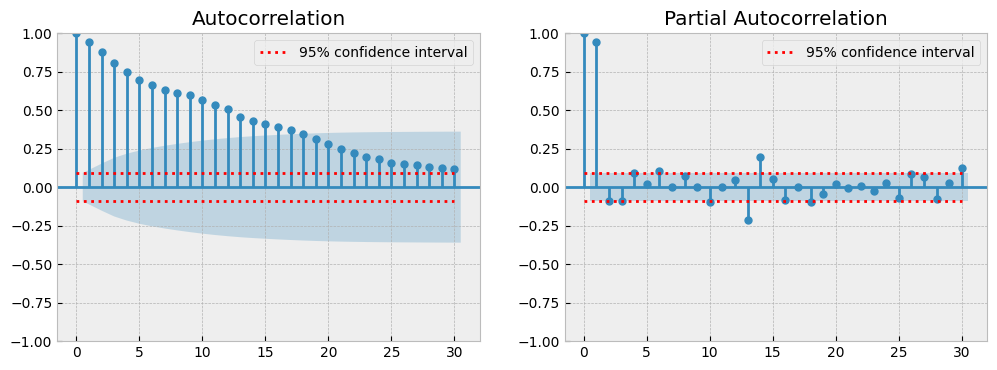

In [16]:
plot_acf_pacf(ret)

## Another view of autocorrelation

In [19]:
def scatter_plots(data, lags):
    fig, axs = plt.subplots(1, 2, figsize=(12,4), subplot_kw={'aspect': 'equal'})
    for ax, lag in zip(axs, lags):
        ax.scatter(data[:-lag], data[lag:], alpha=0.5, marker='.')
        ax.set_ylabel("data at time $t$")
        ax.set_xlabel(f"data at time $t-${lag}")
        ax.set_title(f"Autocorrelation at lag {lag}")

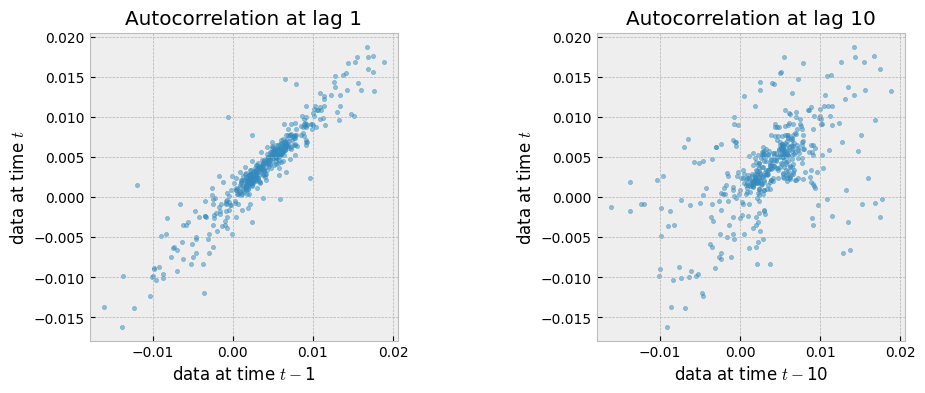

In [20]:
scatter_plots(data=ret, lags=[1, 10])

## Ljung-Box Q test

The [`acf`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.acf.html) function returns the acf values, . With the parameter `qstat=True`, it returns the Ljung-Box Q statistic and its p-values, computed for all lags up to `nlags`.

In [25]:
from statsmodels.tsa.stattools import acf

In [22]:
def print_acf(x, lags):
    val, qstat, pval = acf(x, fft=False, qstat=True, nlags=lags.max())
    df = pd.DataFrame(np.array([qstat[lags-1], 100 * pval[lags-1]]).T,
                      columns=['Q Statistic', 'p-value (%)'],
                      index=[f'up to lag {lag}' for lag in lags]).round(2)
    display(df)

In [26]:
# The H0 is that the coefficient is equal to 0, with the result below, we reject all H0

In [23]:
test_lags = np.array([1, 2, 3, 5, 7, 10])
print_acf(ret, lags=test_lags)

,Q Statistic,p-value (%)
up to lag 1,406.75,0.0
up to lag 2,759.79,0.0
up to lag 3,1058.06,0.0
up to lag 5,1540.04,0.0
up to lag 7,1930.27,0.0
up to lag 10,2421.84,0.0


# Fitting an ARMA model

## Selecting a model with information criteria

Function that displays the output of the [`arma_order_select_ic`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.arma_order_select_ic.html) method.  

- `trend='c'` includes constant  
- `trend='n'` no constant: long run mean is zero

In [27]:
from statsmodels.tsa.stattools import arma_order_select_ic
import warnings # this is to suppress warning messages

In [28]:
def select_arma(x, max_ar=2, max_ma=2, trend='c'):
    with warnings.catch_warnings(action='ignore'):
        res = arma_order_select_ic(
            x,
            max_ar=max_ar,
            max_ma=max_ma,
            ic=['aic', 'bic'],
            trend=trend
            )
    res['aic'].index.names = ['AR Lags']
    res['aic'].columns.names = ['MA Lags']
    res['bic'].index.names = ['AR Lags']
    res['bic'].columns.names = ['MA Lags']
    res['aic'].columns = pd.MultiIndex.from_product([['AIC'],res['aic'].columns])
    res['bic'].columns = pd.MultiIndex.from_product([['BIC'],res['bic'].columns])

    display(res['aic'].round(1))
    print('AIC selected order: ', res['aic_min_order'])
    display(res['bic'].round(1))
    print('BIC selected order: ', res['bic_min_order'])
    
    return res

In [ ]:
res = select_arma(ret, max_ar= 2, max_ma=3)

AIC                        
MA Lags       0       1       2       3
AR Lags                                
0       -3480.0 -3895.8 -4172.7 -4278.3
1       -4471.4 -4472.8 -4476.2 -4475.3
2       -4473.6 -4450.9 -4475.1 -4474.3

AIC selected order:  (np.int64(1), np.int64(2))


BIC                        
MA Lags       0       1       2       3
AR Lags                                
0       -3471.8 -3883.4 -4156.2 -4257.6
1       -4459.0 -4456.3 -4455.6 -4450.6
2       -4457.1 -4430.2 -4450.4 -4445.4

BIC selected order:  (np.int64(1), np.int64(0))


## Estimation of the selected ARMA model

We fit an ARMA model to the data

We use the statsmodel [`ARIMA`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html) class that allows to model up to general SARIMAX models.  

`order = (AR lags, Integration order, MA lags)`  

1. Instantiate the model.
2. Apply the [`fit`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.fit.html) method.
3. Display the fitted model with the `summary` method.

The output is an object of the class [`ARIMAResults`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.html). We use the [`summary()`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.summary.html) method to display the estimated model.

In [31]:
from statsmodels.tsa.arima.model import ARIMA

In [33]:
model = ARIMA(ret, order=(1,0,0))
fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              CSUSHPISA   No. Observations:                  456
Model:                 ARIMA(1, 0, 0)   Log Likelihood                2238.701
Date:                Tue, 01 Apr 2025   AIC                          -4471.401
Time:                        14:03:49   BIC                          -4459.034
Sample:                    02-01-1987   HQIC                         -4466.529
                         - 01-01-2025                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0036      0.002      2.383      0.017       0.001       0.007
ar.L1          0.9417      0.011     82.503      0.000       0.919       0.964
sigma2      3.171e-06   9.23e-08     34.357      0.000    2.99e-06    3.35e-06
===================================================================================
Ljung-Box (L1) (Q):                   3.63   Jarque-Bera (JB):              2225.57
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               4.84   Skew:                             0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# For the (1,0,0) model: The above p-value of the residuals is equal to 0, so we reject H0 that residuals are normally distributed.

# Residuals analysis

The `ARIMAResults` class has a [`ARIMAResults.plot_diagnostics()`](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMAResults.plot_diagnostics.html) method to display an analysis of the residuals.

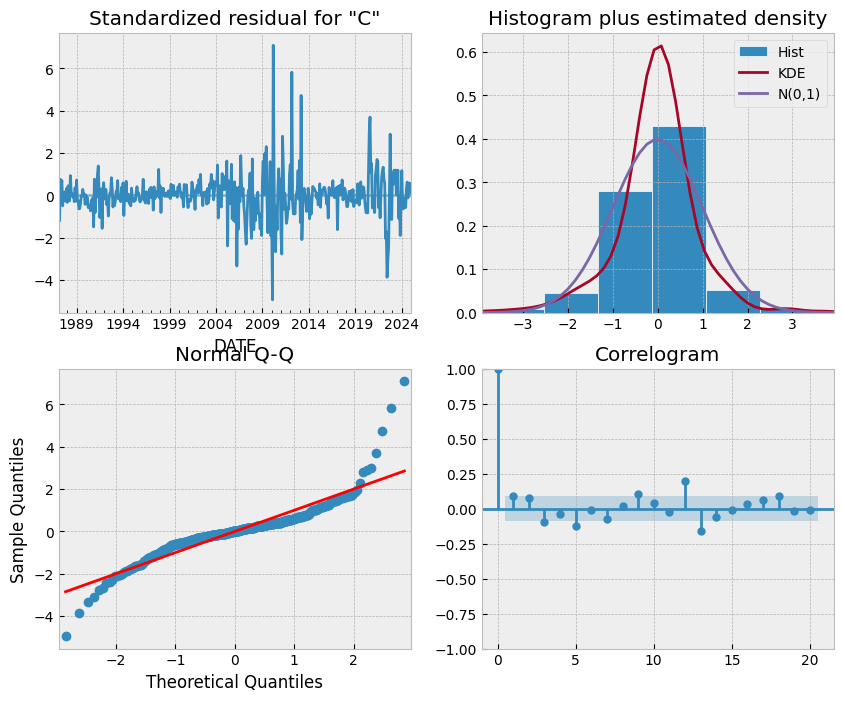

In [37]:
fig = fitted_model.plot_diagnostics(figsize=(10,8), lags=20)

We confirm the absence of autocorrelation seen in the Correlogram with the L-B Q Test.  
This proves that the ARMA model has captured most of the autocorrelation structure that is in the GDQ Q/Q changes data.

We test for autocorrelation using the LB-Q Test applied to the fitted model residuals. These are in the [`resid`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.resid.html) method of the [`ARIMAResults`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.html) object.

In [39]:
res = print_acf(fitted_model.resid, lags=test_lags)

,Q Statistic,p-value (%)
up to lag 1,3.30,6.93
up to lag 2,6.21,4.49
up to lag 3,10.04,1.82
up to lag 5,17.62,0.35
up to lag 7,20.03,0.55
up to lag 10,25.67,0.42


# Forecast

Forecasts are generated by the [`ARIMAResults.get_forecast`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.get_forecast.html) method.  

A forecast is a [`PredictionResults`](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.PredictionResults.html) object which has a [`PredictionResults.summary_frame`](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.PredictionResults.summary_frame.html) method.

In [59]:
forecast = fitted_model.get_forecast(25)

In [60]:
df_forecast = forecast.summary_frame()
df_forecast.head() 

CSUSHPISA,mean,mean_se,mean_ci_lower,mean_ci_upper
2023-01-01,-0.002345,0.001783,-0.005839,0.001149
2023-02-01,-0.002126,0.002564,-0.007151,0.002899
2023-03-01,-0.001683,0.003174,-0.007903,0.004538
2023-04-01,-0.001273,0.003613,-0.008354,0.005807
2023-05-01,-0.000896,0.003948,-0.008633,0.006841


We build two forecasts from two different starting dates.

In [61]:
model = ARIMA(ret[:'2021'], order=(1,0,2))
fitted_model = model.fit()
forecast = fitted_model.get_forecast(50)
df_forecast1 = forecast.summary_frame()

model = ARIMA(ret[:'2022'], order=(1,0,2))
fitted_model = model.fit()
forecast = fitted_model.get_forecast(50)
df_forecast2 = forecast.summary_frame()

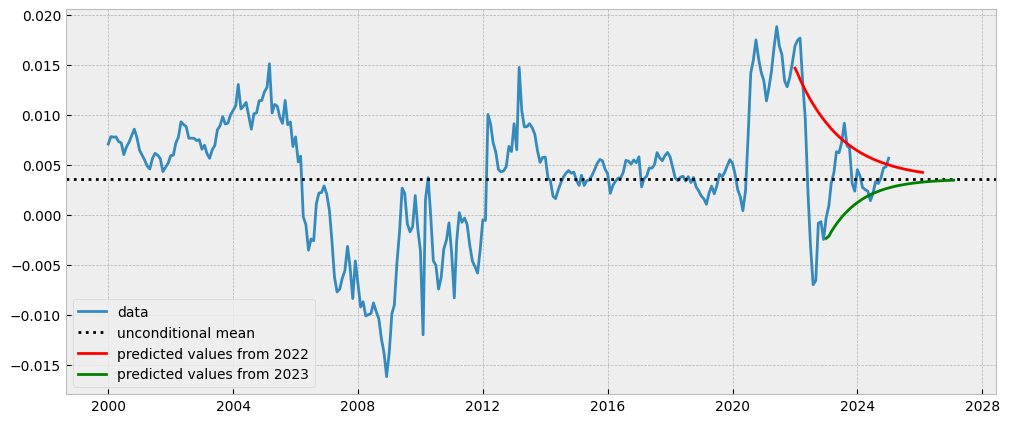

In [62]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(ret['2000':], label="data")
ax.axhline(ret['CSUSHPISA'].mean(), c='k', ls=':', label="unconditional mean")
ax.plot(df_forecast1.index, df_forecast1['mean'], c='r', label="predicted values from 2022")
ax.plot(df_forecast2.index, df_forecast2['mean'], c='g', label="predicted values from 2023")
ax.legend();

<Axes: >

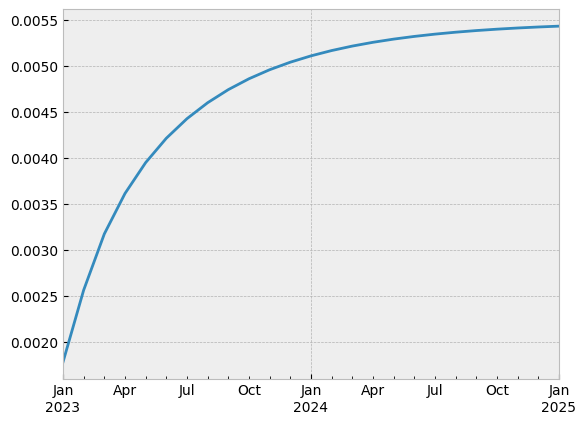

In [66]:
df_forecast['mean_se'].plot()